<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment11/assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing all python packages**

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras.preprocessing import image
import cv2
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Load CIFAR10 dataset

In [0]:
# load CIFAR10 dataset
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

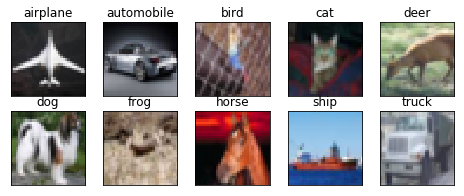

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
batch_sz = 128

# Helper functions

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Cutout function used for image augmentation

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# LR finder

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

# Preprocessing

**Pixel and image normalization**

In [0]:
# pixel normalization
train_X = train_features.astype('float32')/255
test_X = test_features.astype('float32')/255

# convert class labels to binary class labels
train_Y = np_utils.to_categorical(train_labels, num_classes)
test_Y = np_utils.to_categorical(test_labels, num_classes)

**Image Normalization**

In [0]:
# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(train_X)

iterator = datagen.flow(train_X, train_Y, batch_size=len(train_X), shuffle=False)
X_train, Y_train = iterator.next()

iterator = datagen.flow(test_X, test_Y, batch_size=len(test_X), shuffle=False)
X_test, Y_test = iterator.next()

**Image Augmentation: Cutout**

In [0]:
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, pixel_level=True))

#train_iterator = datagen.flow(X_train, Y_train, batch_size=batch_sz,shuffle=False)

#X_e, Y_e = train_iterator.next()

#fig = plt.figure(figsize=(8,3))
#for i in range(10):
#    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
#    im = X_e[i]
#    plt.imshow(im)
#plt.show()

# Model

In [0]:
def define_model():
  
  model = Sequential()
  model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3), name='conv_1'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same',name='conv_2'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2), name='mp_1'))
  model.add(Dropout(0.2))

  model.add(Convolution2D(32, 1, 1, name='conv_3'))


  model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same',name='conv_4'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same',name='conv_5'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2), name='mp_2'))
  model.add(Dropout(0.3))

  model.add(Convolution2D(32, 1, 1, name='conv_6'))


  model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same',name='conv_7'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same',name='conv_8'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2),name='mp_3'))
  model.add(Dropout(0.5))

  model.add(Convolution2D(10, 1, 1, name='conv_9'))

  model.add(AveragePooling2D(pool_size = (4,4), name='avg_pool'))
  model.add(Flatten())


  model.add(Activation('softmax'))
  
  return model

# Find optimal LR

In [14]:
model_lr_finder = define_model()
model_lr_finder.summary()

W0721 10:23:32.072701 140282615449472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., name="conv_1", padding="same")`
  after removing the cwd from sys.path.
W0721 10:23:32.087539 140282615449472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 10:23:32.091510 140282615449472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 10

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
mp_1 (MaxPooling2D)          (None, 16, 16, 64)        0         
__________

In [15]:
# Compile the model
model_lr_finder.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/batch_sz))
model_lr_finder.fit(X_train, Y_train, callbacks=[lr_finder] )

W0721 10:23:33.361731 140282615449472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0721 10:23:33.550609 140282615449472 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
12832/50000 [======>.......................] - ETA: 19s - loss: 3.9608 - acc: 0.1638

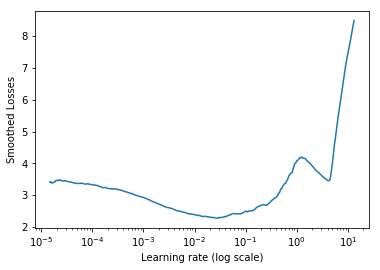

In [16]:
lr_finder.plot_smoothed_loss()

Minimum loss appears to be around 0.01

# Train model with the best LR

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., name="conv_1", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv_2", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), name="conv_3")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., name="conv_4", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` ca

Epoch 1/100
391/390 [==============================] - 14s 36ms/step - loss: 1.9031 - acc: 0.3187 - val_loss: 1.8624 - val_acc: 0.3949

Epoch 00001: val_acc improved from -inf to 0.39490, saving model to assign11
Epoch 2/100
391/390 [==============================] - 12s 31ms/step - loss: 1.5347 - acc: 0.4567 - val_loss: 1.4878 - val_acc: 0.5020

Epoch 00002: val_acc improved from 0.39490 to 0.50200, saving model to assign11
Epoch 3/100
391/390 [==============================] - 12s 31ms/step - loss: 1.3482 - acc: 0.5328 - val_loss: 1.2227 - val_acc: 0.5764

Epoch 00003: val_acc improved from 0.50200 to 0.57640, saving model to assign11
Epoch 4/100
391/390 [==============================] - 12s 31ms/step - loss: 1.2294 - acc: 0.5764 - val_loss: 1.1580 - val_acc: 0.6134

Epoch 00004: val_acc improved from 0.57640 to 0.61340, saving model to assign11
Epoch 5/100
391/390 [==============================] - 12s 31ms/step - loss: 1.1309 - acc: 0.6126 - val_loss: 1.2200 - val_acc: 0.5967

Epo

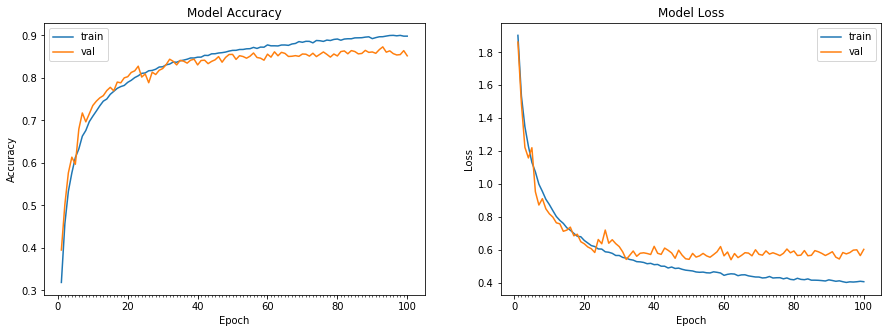

Accuracy on test data is: 87.29


In [17]:
model = define_model()

model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint("assign11",verbose=1,save_best_only=True, monitor='val_acc', mode='max')


start = time.time()
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_sz, shuffle=True),
                                 steps_per_epoch = X_train.shape[0]/batch_sz, nb_epoch = 100, 
                                 validation_data = (X_test, Y_test), callbacks=[checkpoint], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


# plot model history
plot_model_history(model_info)

# compute test accuracy
model.load_weights("assign11")
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model))

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
mp_1 (MaxPooling2D)          (None, 16, 16, 64)        0         
__________

# Gradcam on 25 misclassified images

In [0]:
# grad cam function to visualize layers of a model

def gradCam(model, x, inputImg, layer, numCh, class_idx=-1):
  
  if(-1 == class_idx):
    preds = model.predict(x)
    class_idx = np.argmax(preds, axis=1)[0]
    
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(numCh):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  img1 = np.uint8(image.img_to_array(inputImg))
  superimposed_img = cv2.addWeighted(img1, 0.6, heatmap, 0.4, 0)
  
  return(img1,superimposed_img)

In [0]:
# Predict the labels for each of the image in the testing set
y_pred = model.predict(X_test)

# convert categorical matrix back to class labels. argmax returns the index of the maximum value along an axis
y_pred_label = np.argmax(y_pred,axis=1)

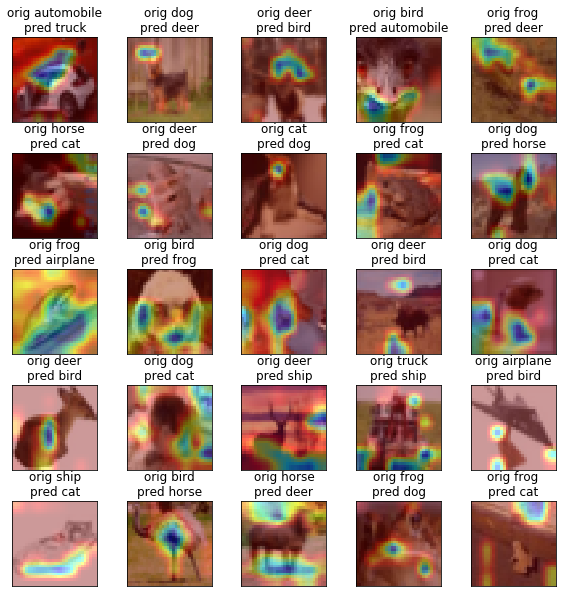

In [21]:
# plotting 25 misclassified images


from matplotlib import pyplot as plt

# Set up the display matix to display 25 images
fig, ax = plt.subplots(5, 5, figsize = (4,4))
fig.tight_layout(pad = 0.3, h_pad= 1, rect = [0, 0, 2, 2])
counter = 0


# Compare labels of prediction and original to get the misclassified images
for indx in range(Y_test.shape[0]):
  if y_pred_label[indx] != test_labels[indx]:
    img, sup = gradCam(model, X_test[indx].reshape(1,32,32,3), test_features[indx], 'conv_8', 256)
    ax[counter//5][counter%5].set_xticks([])
    ax[counter//5][counter%5].set_yticks([])
    ax[counter//5][counter%5].imshow(sup)
    ax[counter//5][counter%5].set_title('orig %s\npred %s' % (class_names[int(test_labels[indx])], class_names[y_pred_label[indx]]))   
    counter += 1
  if counter >= 25:
    break